# Supervised Model RFC Classification with 2 classes and 4 features

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f2eca345690>

MLfit applied to 4FGL-DR4 

Scikit-learn specifications: 
* features: log_var, log_fpeak, log_epeak, sqrt_d
* classes: pulsar, blazar
* model: RandomForestClassifier(max_features=2)
        

## Feature distributions 

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f2eca475990>
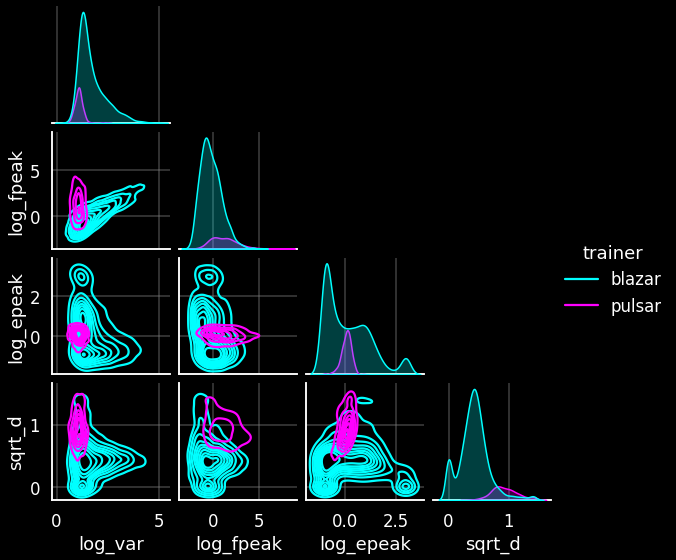

Expand the important pairs

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f2ec9dda380>
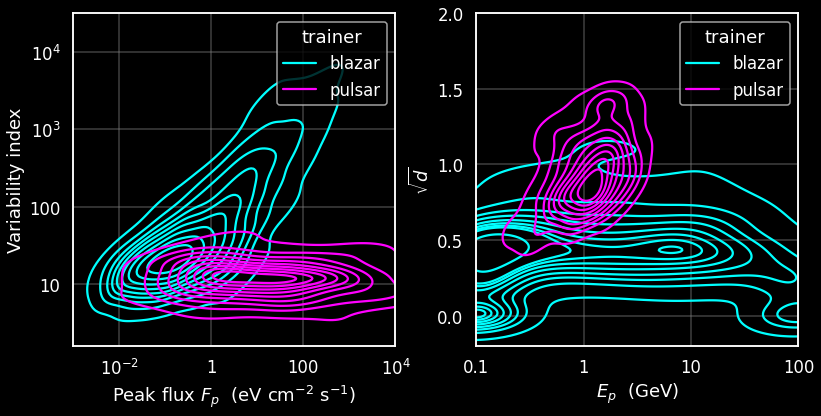

## Train then apply prediction, add probs 

### Accuraccy for pulsar/blazar separation
A standard classification performance metric, the accuracy  "ROC-AUC", is described in 
Luo at al.

With our model "RandomForestClassifier" we obtain (99.28$\pm$ 0.04)%

Compare this with 
     [Luo et al (2020)](https://academic.oup.com/mnras/article/492/4/5377/5709930), who achieved 
     (99.17$\pm$ 0.17)% with three features, also with Random Forest.

### All predictions

prediction,blazar,pulsar
class_group,,
blazar,2283,0
pulsar,0,316
egal,85,3
Gal,92,131
unID,3002,901


<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f2eca083f10>
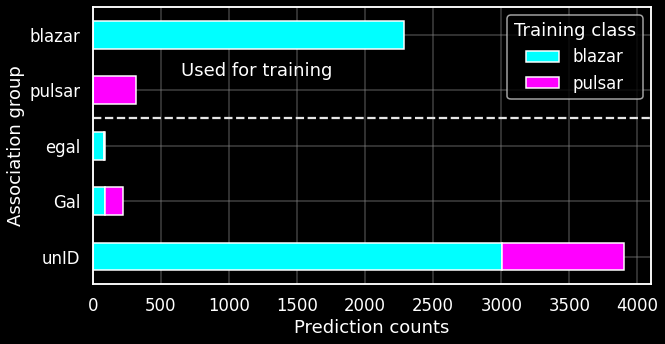

## The issue with this
In figure 1.4, we show plots of the pulsar probability vs.  $E_p$ for the training classes, in 
 the upper panel and for the unID in the lower, wich colors corresponding to the class prediction.

The large number of unID sources with intermediate probabilites is inconsistent with
 a mixture of the two classes. 

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f2ec99cb790>
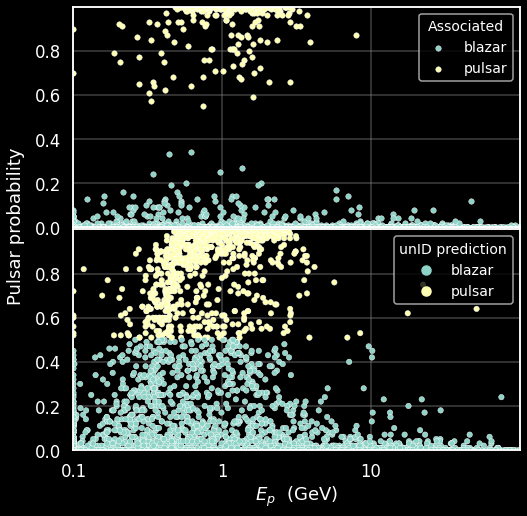

File `files/dr4_2_class_4_features.csv` exists--not overwriting.


In [2]:
# Set "paper" to "dark" for developmet. "paper" generaes figures foa a paper
%reset -f
%run pylib/ml_fit dark doc

In [2]:
if dark_mode:
    self=doc(nc=2,nf=2);